In [1]:
import pandas as pd
import io
import requests
import numpy as np
import os

import tensorflow.contrib.learn as skflow
import string

from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing


path = "../../966MB_UGR16.csv"
# This file is a CSV, just no CSV extension or headers
df = pd.read_csv(path, header=None, chunksize=200000)


ENCODING = 'utf-8'

def expand_categories(values):
	result = []
	s = values.value_counts()
	t = float(len(values))
	for v in s.index:
		result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
	return "[{}]".format(",".join(result))
		
def analyze(filename):
	print()
	print("Analyzing: {}".format(filename))
	df = pd.read_csv(filename,encoding=ENCODING)
	cols = df.columns.values
	total = float(len(df))

	print("{} rows".format(int(total)))
	for col in cols:
		uniques = df[col].unique()
		unique_count = len(uniques)
		if unique_count>100:
			print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
		else:
			print("** {}:{}".format(col,expand_categories(df[col])))
			expand_categories(df[col])

analyze(path)

Using TensorFlow backend.



Analyzing: ../../966MB_UGR16.csv
9999998 rows
** 2016-03-18 10:52:40:10719 (0%)
** 0.000:35412 (0%)
** 127.204.60.89:892565 (8%)
** 42.219.153.89:4098 (0%)
** 123:65536 (0%)
** 425:64147 (0%)
** UDP:[TCP:62.27%,UDP:36.56%,ICMP:1.05%,GRE:0.06%,ESP:0.05%,IPIP:0.01%,IPv6:0.0%]
** .A....:[.A....:40.27%,.AP.SF:26.33%,.AP.S.:7.04%,.AP...:6.6%,.APRSF:4.37%,.A...F:4.04%,....S.:2.5%,.APRS.:2.18%,.AP..F:1.85%,.A..SF:1.66%,.A.R..:0.87%,.A..S.:0.64%,.A.R.F:0.45%,...R..:0.45%,.APR..:0.44%,.APR.F:0.18%,.A.RS.:0.06%,...RS.:0.04%,.A.RSF:0.02%,......:0.01%,UAP..F:0.0%,UAP.S.:0.0%,..P.S.:0.0%]
** 0:[0:100.0%]
** 0.1:[0:66.46%,40:20.13%,72:8.62%,8:1.48%,64:1.3%,42:0.76%,24:0.4%,2:0.39%,26:0.17%,104:0.07%,75:0.05%,16:0.04%,20:0.02%,192:0.02%,74:0.02%,96:0.01%,28:0.01%,4:0.01%,224:0.01%,43:0.01%,6:0.0%,18:0.0%,12:0.0%,184:0.0%,32:0.0%,73:0.0%,10:0.0%,152:0.0%,23:0.0%,88:0.0%,13:0.0%,3:0.0%,48:0.0%,66:0.0%,160:0.0%,56:0.0%,194:0.0%,80:0.0%,15:0.0%,25:0.0%,9:0.0%,1:0.0%,17:0.0%,14:0.0%,92:0.0%,200:0.0%,19:0

['anomaly-spam' 'background' 'blacklist']
(6899999, 46)
   duration       sip       dip  source_port  dest_port  forward_status  \
0    48.380  0.073637  0.001654           53         53               0   
1    48.380  0.001654  0.073637           53         53               0   
2    50.632  0.165401  0.243698           80       1838               0   

   type_service  pack_exch  bytes  attack_tag  ...  flags-.APR..  \
0             0          2    209           1  ...             0   
1             0          2    167           1  ...             0   
2             0          9   2082           1  ...             0   

   flags-.APR.F  flags-.APRS.  flags-.APRSF  flags-U.....  flags-U.PRSF  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   flags-UA...F  flags-UA..SF  flags-UA.R.F  flags-UAPRSF  
0        

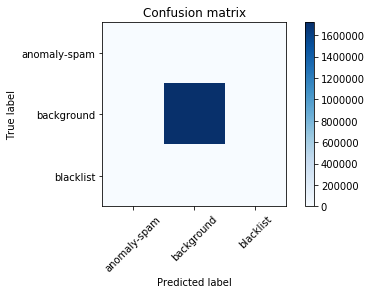

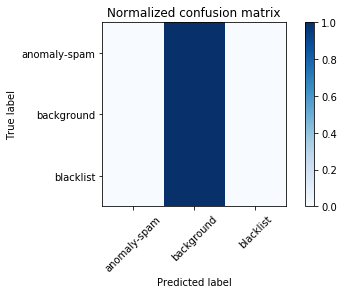

In [6]:
import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing


path = "../../july_reduced.csv"
# This file is a CSV, just no CSV extension or headers
df = pd.read_csv(path, header=None)


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

#MINMAX 0 1
def min_max_0(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





#print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
#df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)


# The CSV file has no column heads, so add them
df.columns = [
    'time',
    'duration',
    'sip',
    'dip',
    'source_port',
    'dest_port',
    'protocol',
    'flags',
    'forward_status',
    'type_service',
    'pack_exch',
    'bytes',
    'attack_tag'
]

#print(df[0:3])

ENCODING = 'utf-8'



# #LAS QUE YA SON NUMEROS --> no los normalizo de momento
# min_max_1(df, 'duration')
# min_max_1(df, 'source_port')
# min_max_1(df, 'dest_port')
# min_max_1(df, 'forward_status')
# min_max_1(df, 'type_service')
# min_max_1(df, 'pack_exch')
# min_max_1(df, 'bytes')

df.drop('time', 1, inplace=True)

encode_text_dummy(df, 'protocol')
encode_text_dummy(df, 'flags')
#encode_text_dummy(df, 'attack_tag')

outcomes = encode_text_index(df, 'attack_tag')
num_classes = len(outcomes)
print(outcomes)

#Me crea una columna AL FINAL nueva con los valores transformdos asi 20160318105240
#df['time'] = df['time'].apply(clean_date)

df['sip'] = df['sip'].apply(clean_ip)
df['dip'] = df['dip'].apply(clean_ip)

#encode_numeric_zscore(df, 'time')
min_max_0(df, 'sip')
min_max_0(df, 'dip')


print(df.shape)
print(df[0:3])


##################################################
# Break into X (predictors) & y (prediction)
x, y = to_xy(df,'attack_tag')
#################################################



# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

print(outcomes)

# Not normalized
cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

plt.show()

In [7]:
y_score = model.decision_function(X_test)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

AttributeError: 'Sequential' object has no attribute 'decision_function'

In [8]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_eval)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_eval)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
from sklearn.metrics import roc_curve, auc
#Plot an ROC. pred - the predictions, y - the expected outpus.
#En mi caso creo que es pred == pred y== y_eval
def plot_roc(pred, y):
	fpr, tpr, _ = roc_curve(y, pred)
	roc_auc = auc(fpr,tpr)

	plt.figure()
	plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver Operating Characteristic (ROC)')
	plt.legend(loc="lower rigth")
	plt.show()


['background' 'blacklist']
(49636, 35)
   duration       sip      dip  source_port  dest_port  forward_status  \
0       0.0  0.072736  0.01654          443       3673               0   
1       0.0  0.072736  0.01654          443       3675               0   
2       0.0  0.733522  0.01654          443      53081               0   

   type_service  pack_exch  bytes  attack_tag  ...  flags-.A.RS.  \
0             0          1     40           0  ...             0   
1             0          1     40           0  ...             0   
2            72          1     72           0  ...             0   

   flags-.A.RSF  flags-.AP...  flags-.AP..F  flags-.AP.S.  flags-.AP.SF  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             1             0             0             0   

   flags-.APR..  flags-.APR.F  flags-.APRS.  flags-.APRSF  
0             0             0 

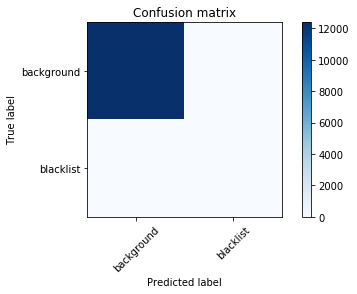

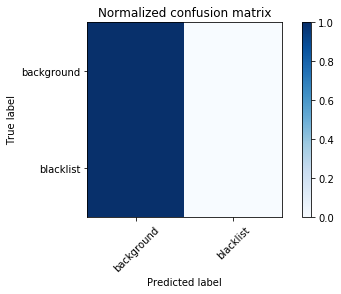

In [10]:
import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing


path = "../../july_reduced.csv"
# This file is a CSV, just no CSV extension or headers
df = pd.read_csv(path, header=None)


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

#MINMAX 0 1
def min_max_0(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





#print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
#df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)


# The CSV file has no column heads, so add them
df.columns = [
    'time',
    'duration',
    'sip',
    'dip',
    'source_port',
    'dest_port',
    'protocol',
    'flags',
    'forward_status',
    'type_service',
    'pack_exch',
    'bytes',
    'attack_tag'
]

#print(df[0:3])

ENCODING = 'utf-8'



# #LAS QUE YA SON NUMEROS --> no los normalizo de momento
# min_max_1(df, 'duration')
# min_max_1(df, 'source_port')
# min_max_1(df, 'dest_port')
# min_max_1(df, 'forward_status')
# min_max_1(df, 'type_service')
# min_max_1(df, 'pack_exch')
# min_max_1(df, 'bytes')

df.drop('time', 1, inplace=True)

encode_text_dummy(df, 'protocol')
encode_text_dummy(df, 'flags')
#encode_text_dummy(df, 'attack_tag')

outcomes = encode_text_index(df, 'attack_tag')
num_classes = len(outcomes)
print(outcomes)

#Me crea una columna AL FINAL nueva con los valores transformdos asi 20160318105240
#df['time'] = df['time'].apply(clean_date)

df['sip'] = df['sip'].apply(clean_ip)
df['dip'] = df['dip'].apply(clean_ip)

#encode_numeric_zscore(df, 'time')
min_max_0(df, 'sip')
min_max_0(df, 'dip')


print(df.shape)
print(df[0:3])


##################################################
# Break into X (predictors) & y (prediction)
x, y = to_xy(df,'attack_tag')
#################################################



# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

print(outcomes)

# Not normalized
cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

plt.show()

from sklearn.metrics import roc_curve, auc
#Plot an ROC. pred - the predictions, y - the expected outpus.
#En mi caso creo que es pred == pred y== y_eval
def plot_roc(pred, y):
	fpr, tpr, _ = roc_curve(y, pred)
	roc_auc = auc(fpr,tpr)

	plt.figure()
	plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver Operating Characteristic (ROC)')
	plt.legend(loc="lower rigth")
	plt.show()

/miniconda3/envs/tf_jupyter/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/miniconda3/envs/tf_jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:249: MatplotlibDeprecationWarning: Unrecognized location 'lower rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


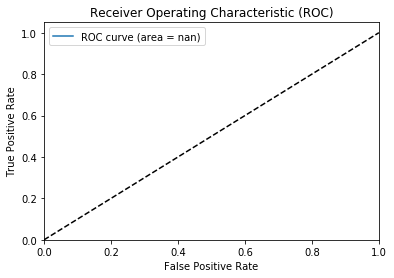

In [11]:
plot_roc(y_eval, pred)

/miniconda3/envs/tf_jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:249: MatplotlibDeprecationWarning: Unrecognized location 'lower rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


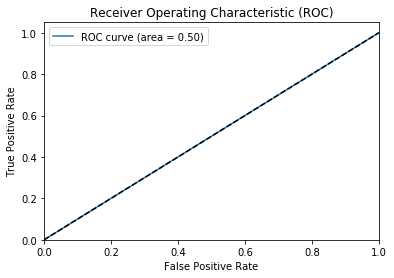

In [12]:
plot_roc(pred, y_eval)